In [1]:
from __future__ import absolute_import, division, print_function

import sys
import os
import time
import pickle
from math import ceil, floor, sqrt

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from IPython.display import Image

import tensorflow as tf

from sklearn import model_selection,preprocessing
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD, Adam
from keras.regularizers import l1,l2, l1_l2
from keras.models import load_model
from keras.utils import plot_model, np_utils

# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from dataset import Dataset
from database import Database
from sample import Sample
from sample_detector import SampleDetector

# matplotlib.get_backend()
%matplotlib inline

# use gpu
print('GPUs:',K.tensorflow_backend._get_available_gpus())
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


GPUs: ['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
my_database = Database(dataset_loc, database_loc, site)

In [9]:
transforms = ['zscore']
transforms_params = [[None]]
X, Y, _X, _Y = my_database.augmented_events(transforms=transforms, transforms_params=transforms_params, cut_time=0.7, cut_time_split=0.3, cut_freq=7.5,cut_freq_min=2.5, time_err=0.3,noise=True, test=False)
__X, __Y = my_database.augmented_data(X,Y,_X,_Y)
# __X, __Y = X, Y

/home/othniel/wdml/data/databases/awdEvents1/marion/marion_h5/['zscore']_[[None]]_[0.7, 0.3, 7.5, 2.5, 0.3]_True/train
samples:  8935


100%|██████████| 8935/8935 [00:02<00:00, 3800.48it/s]


#### print(Y[:20])
plt.pcolormesh(X[8], cmap='jet'); plt.show()

In [10]:
freq_len, time_len = __X[0].shape
data = __X.reshape(len(__X),freq_len*time_len)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
data = data.reshape((len(data),1,freq_len,time_len))
evt = np_utils.to_categorical(__Y)
print(__X.shape, __Y.shape)
print(data.shape,evt.shape)
print(__Y)

(13417, 48, 108) (13417,)
(13417, 1, 48, 108) (13417, 5)
[0 0 2 ... 0 0 0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 16, 48, 108)       800       
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 48, 108)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 48, 108)       30992     
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 48, 108)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 48, 108)        56456     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 24, 54)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 4, 24, 54)         14116     
__________

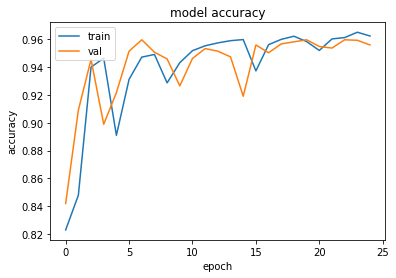

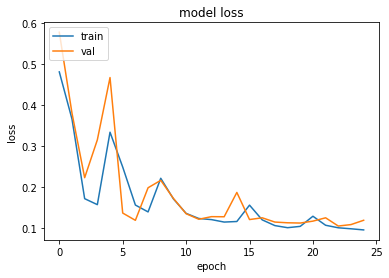

In [22]:
model = Sequential()
model.add(Conv2D(16,(7,7), input_shape=(1,freq_len, time_len),
                    padding='same', activation='relu',data_format='channels_first'))
model.add(Dropout(0.6))
model.add(Conv2D(16, (11,11), activation='relu', padding='same',data_format='channels_first'))
model.add(Dropout(0.7))
model.add(Conv2D(8, (21,21), activation='relu', padding='same',data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Conv2D(5, (21,21), activation='relu', padding='same',data_format='channels_first'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

#compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

# fit model
history = model.fit(data, evt, validation_split=0.3, epochs=epochs, batch_size=250, shuffle=True)
print(history.history.keys())

# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
aug=False
params = str(transforms)+'_'+str(transforms_params)
params +='_aug' if aug else ''

# save scaler
standard_scaler = {"scaler": scaler}
scaler_path = os.path.join(database_loc,site,'models',params+'_scaler.pickle')
pickle.dump( standard_scaler, open(scaler_path, "wb" ) )

# save history
_history = {"history": history}
history_path = os.path.join(database_loc,site,'models',params+'_history.pickle')
pickle.dump( _history, open(history_path, "wb" ) )

# save model
model_path = os.path.join(database_loc,site,'models',params+'_model.h5')
model.save(model_path)

In [8]:
    def get_conv_layers(model):
        layers = []
        # summarize filter shapes
        for layer in model.layers:
            # check for convolutional layer
            if 'conv' not in layer.name:
                continue
            # get filter weights
            layers.append(layer)
        return layers

    def visualization(model,summary=False, plot=False, conv_layer_number=0):
        '''Visualize the CNN model'''
        if summary:
            print(model.summary())
        if plot:
            path = os.path.join(database_loc,site,'models','model.png')
            plot_model(model, show_shapes=True, show_layer_names=True, to_file=path)
            Image(retina=True, filename=path)
        # get filers and biases
        filters, biases = get_conv_layers(model)[conv_layer_number].get_weights()
        # scale filters
        f_min, f_max = filters.min(), filters.max()
        filters = (filters-f_min)/(f_max-f_min)
        # get number of filters
        n_filters, ix = filters.shape[-1], 1

        for i in range(n_filters):
            # get the filters
            f = filters[:,:,:,i]
            # plot each channel seperately
            for j in range(1):
                # specify subplot and turn of axis
                ax = plt.subplot(1,n_filters, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(f[:, :, j], cmap='jet')
                ix += 1
        plt.show()

    def visualization_fm(model,train_X, conv_layer_number=0):
        data = train_X[np.random.randint(len(train_X))]# get filers and biases
        filters, biases = get_conv_layers(model)[conv_layer_number].get_weights()
        # scale filters
        f_min, f_max = filters.min(), filters.max()
        filters = (filters-f_min)/(f_max-f_min)
        # get number of filters
        n_filters, ix = filters.shape[-1], 1
        feature_maps = model.predict([data])
        for i in range(n_filters):
            # get the filters
            f = filters[:,:,:,i]
            # plot each channel seperately
            for j in range(1):
                # specify subplot and turn of axis
                ax = plt.subplot(1,n_filters, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.pcolormesh(f[:, :, j], cmap='jet')
                ix += 1
        plt.show()
    
    def show_history(history):
        print(history.history.keys())
        # summarize history for accuracy
        plt.figure()
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


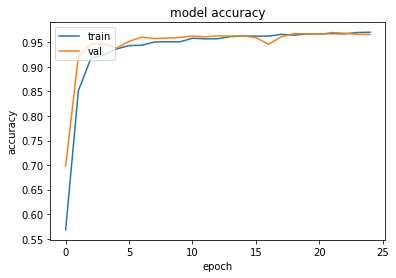

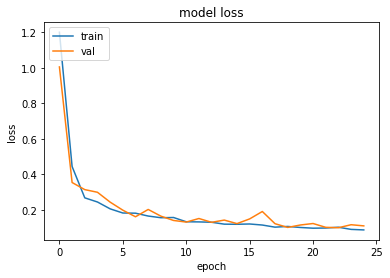

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 16, 48, 108)       800       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 48, 108)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 48, 108)       30992     
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 48, 108)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 48, 108)        56456     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 24, 54)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 24, 54)         14116     
__________

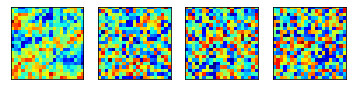

/home/othniel/wdml/data/databases/awdEvents1/marion/marion_h5/['zscore']_[[None]]_[0.7, 0.3, 7.5, 2.5, 0.3]_True/train
samples:  8935


100%|██████████| 8935/8935 [00:02<00:00, 3248.16it/s]


In [9]:
from sample import Sample
from dataset import Dataset
from database import Database
dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
my_database = Database(dataset_loc, database_loc, site)

aug=True
transforms, transforms_params = ['zscore'],[[None]]
params = str(transforms)+'_'+str(transforms_params)
params +='_aug' if aug else ''
scaler_path = os.path.join(database_loc,site,'models',params+'_scaler.pickle')
history_path = os.path.join(database_loc,site,'models',params+'_history.pickle')
model_path = os.path.join(database_loc,site,'models',params+'_model.h5')
input_shape = [48,108]

scaler = pickle.load( open( scaler_path, "rb" ) )['scaler']
history = pickle.load( open( history_path, "rb" ) )['history']
model = load_model(model_path)

show_history(history)
visualization(model,summary=True, plot=True, conv_layer_number=3)

X, Y, _X, _Y = my_database.augmented_events(transforms=transforms, transforms_params=transforms_params, cut_time=0.7, cut_time_split=0.3, cut_freq=7.5,cut_freq_min=2.5, time_err=0.3,noise=True, test=False)
# __X, __Y = my_database.augmented_data(X,Y,_X,_Y)
__X, __Y = X, Y
freq_len, time_len = __X[0].shape
data = __X.reshape(len(__X),freq_len*time_len)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
data = data.reshape((len(data),1,freq_len,time_len))
# visualization_fm(model,[data], conv_layer_number=3)